In [1]:
# pip install datasets
from datasets import load_dataset

/Users/federicomarchi/Desktop/BigData&TextMining/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/federicomarchi/Desktop/BigData&TextMining/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_abstractive = load_dataset("sobamchan/aclsum", "abstractive", split="test")
dataset_extractive = load_dataset("sobamchan/aclsum", "extractive", split="test")

In [3]:
dataset_abstractive_temp = dataset_abstractive[:5]
dataset_extractive_temp = dataset_extractive[:5]

Let's import **ROUGE**

In [4]:
#pip install evaluate absl-py nltk rouge-score
from evaluate import load

In [5]:
rouge = load("rouge")

In [6]:
# Possibilities for rouge parameter are:  "rouge1", "rouge2", "rougeL"
def rouge_score(candidate, reference, rougex):
    result = rouge.compute(
        predictions=[candidate],
        references=[reference],
        rouge_types=[rougex]
    )
    r1 = result[rougex]
    return r1

### Let's define funcitons for **Summary-level's** strategies
#### **Greedy Search**


In [7]:
def greedy_extractive_summary(sentences, abstractive_summaries, eval_criteria, max_sent):
    selected = []
    remaining = sentences[:]
    #mask = [0] * len(sentences)

    while remaining and max_sent != 0: 
        best_sentence = None
        best_score = -1
        for sent in remaining:
            
            candidate_summary = " ".join(selected + [sent])
            r1 = rouge_score(candidate_summary, abstractive_summaries, eval_criteria)
            if r1 > best_score:
                best_score = r1
                best_sentence = sent
       
        selected.append(best_sentence)
        idx = sentences.index(best_sentence)
        #mask[idx] = 1
        remaining.remove(best_sentence)
        max_sent -= 1
    
    #return selected, mask
    return selected

#### **Beam Search**

In [76]:
def beam_extractive_summary(sentences, abstractive_summary, eval_criteria, max_sent, beam_size=4, with_score=False):
    # Tuple of two items:
    #   -   selected sentences array
    #   -   ROUGE score
    beams = [([], 0.0)]
    
    for _ in range(min(max_sent, len(sentences))):
        new_beams = []
        for selected, _ in beams:
            remaining = [s for s in sentences if s not in selected]
            
            for sent in remaining:
                candidate_summary = " ".join(selected + [sent])
                r1 = rouge_score(candidate_summary, abstractive_summary, eval_criteria)
                
                new_beams.append((selected + [sent], r1))
        if not new_beams:
            break
        # Sort by third value (ROUGE F1 score), highest score first
        new_beams.sort(key=lambda x: x[1], reverse=True)
        # Takes only the first beam_size elements
        beams = new_beams[:beam_size]
    if with_score:
        return beams 
    return beams[0][0]

### Let's define funcitons for **Sentence-level's** strategies
#### **Local Scorer**


In [9]:
def local_extractive_summary(sentences, abstractive_summaries, eval_criteria, max_sent):
    def rank_sentences():
        sent_with_score = []
        for sent in sentences:
            r1 = rouge_score(sent, abstractive_summaries, eval_criteria)
            sent_with_score.append({"sentence": sent, "r_score": r1})
        sent_with_score.sort(key=lambda x: x["r_score"], reverse=True)
        return [sent["sentence"] for sent in sent_with_score]

    sorted_sentences = rank_sentences()
    return sorted_sentences[:max_sent]

#### **Global Scorer**
As heuristic in order to find the best candidates we will use **Beam Search** heuristic.

In [10]:
def global_extractive_summary(sentences, abstractive_summary, eval_criteria, max_sent, beam_size=4):
    candidates = beam_extractive_summary(sentences, abstractive_summary, eval_criteria, max_sent, beam_size, True)
    unique_sent_in_candidates = list(set([sent for candidate in [sents for sents, _ in candidates] for sent in candidate]))
    unique_sent_with_scores = []
    
    for sent in unique_sent_in_candidates:
        final_score = 0
        for cand, score in candidates:
            if sent in cand:
                final_score += score
        unique_sent_with_scores.append((sent, final_score))
    
    sorted_unique_sent_with_scores = sorted(unique_sent_with_scores, key=lambda x: x[1], reverse=True)

    best_sentences = [sent for sent, _ in sorted_unique_sent_with_scores][:max_sent]

    return best_sentences

### Let's now define a function to iterate over all documents
It will also keep track of the **time** taken from each algorithm in order to compute all the results. 

In [11]:
import time

In [12]:
def apply_heuristic_to_dataset(heuristic_fn, docs_sentences, abstractive_summaries, eval_criteria, max_sent=6, beam_size=0):
    selected_list = []
    start_time = time.perf_counter()
    for sentences, abs_summary in zip(docs_sentences, abstractive_summaries):
        if beam_size > 0:
            selected = heuristic_fn(sentences, abs_summary, eval_criteria, max_sent, beam_size)
        else:
            selected = heuristic_fn(sentences, abs_summary, eval_criteria, max_sent)
            
        selected_list.append(selected)

    elapsed_time = time.perf_counter() - start_time

    return selected_list, elapsed_time

### Let's first apply each heuristic once for each summary (**Challenge**, **Approach**, **Outcome**) 

As evaluation criteria we will first use **ROUGE F-1**

In [13]:
evaluation_criteria = "rouge1"

Since we want to grid search in the interval [1, 32] in order to determine which value for **max_sent** is the best, we will use 32. We will then use a beam size of 4 to avoid huge complexity.

In [14]:
max_sentences = 32
beam_sie = 4

In [15]:
# Take the list of all source sentences from extractive dataset
#list_source_sentences = list(dataset_extractive["source_sentences"])
list_source_sentences = list(dataset_extractive_temp["source_sentences"])

Let's create a dictionary to keep track of all the results we will get.

In [51]:
results = {
    "challenge": {
        "greedy_search": {
            "result": [],
            "time": None
        },
        "beam_search": {
            "result": [],
            "time": None
        },
        "local_score": {
            "result": [],
            "time": None
        },
        "global_score":{
            "result": [],
            "time": None
        },
    },
    "approach": {
        "greedy_search": {
            "result": [],
            "time": None
        },
        "beam_search": {
            "result": [],
            "time": None
        },
        "local_score": {
            "result": [],
            "time": None
        },
        "global_score":{
            "result": [],
            "time": None
        },
    },
    "outcome": {
        "greedy_search": {
            "result": [],
            "time": None
        },
        "beam_search": {
            "result": [],
            "time": None
        },
        "local_score": {
            "result": [],
            "time": None
        },
        "global_score":{
            "result": [],
            "time": None
        },
    },
    "all_together": {
        "greedy_search": {
            "result": [],
            "time": None
        },
        "beam_search": {
            "result": [],
            "time": None
        },
        "local_score": {
            "result": [],
            "time": None
        },
        "global_score":{
            "result": [],
            "time": None
        },
    }
}

#### **Challenge** summaries

In [52]:
# Take the list of all challenge sentences from abstractive dataset
#list_challenge_summaries = list(dataset_abstractive["challenge"])
list_challenge_summaries = list(dataset_abstractive_temp["challenge"])

In [53]:
# Greedy Search
results["challenge"]["greedy_search"]["result"], results["challenge"]["greedy_search"]["time"] = apply_heuristic_to_dataset(
    greedy_extractive_summary, list_source_sentences, list_challenge_summaries, evaluation_criteria, max_sentences)

In [77]:
# Beam Search
results["challenge"]["beam_search"]["result"], results["challenge"]["beam_search"]["time"] = apply_heuristic_to_dataset(
    beam_extractive_summary, list_source_sentences, list_challenge_summaries, evaluation_criteria, max_sentences, beam_sie)

In [55]:
# Local Scorer
results["challenge"]["local_score"]["result"], results["challenge"]["local_score"]["time"] = apply_heuristic_to_dataset(
    local_extractive_summary, list_source_sentences, list_challenge_summaries, evaluation_criteria, max_sentences)

In [56]:
# Global Scorer
results["challenge"]["global_score"]["result"], results["challenge"]["global_score"]["time"]  = apply_heuristic_to_dataset(
    global_extractive_summary, list_source_sentences, list_challenge_summaries, evaluation_criteria, max_sentences, beam_sie)

#### **Approach**

In [57]:
list_approach_summaries = list(dataset_abstractive_temp["approach"])

In [58]:
# Greedy Search
results["approach"]["greedy_search"]["result"], results["approach"]["greedy_search"]["time"] = apply_heuristic_to_dataset(
    greedy_extractive_summary, list_source_sentences, list_approach_summaries, evaluation_criteria, max_sentences)

# Beam Search
results["approach"]["beam_search"]["result"], results["approach"]["beam_search"]["time"] = apply_heuristic_to_dataset(
    beam_extractive_summary, list_source_sentences, list_approach_summaries, evaluation_criteria, max_sentences, beam_sie)

# Local Score
results["approach"]["local_score"]["result"], results["approach"]["local_score"]["time"] = apply_heuristic_to_dataset(
    local_extractive_summary, list_source_sentences, list_approach_summaries, evaluation_criteria, max_sentences)

# Global Score
results["approach"]["global_score"]["result"], results["approach"]["global_score"]["time"]  = apply_heuristic_to_dataset(
    global_extractive_summary, list_source_sentences, list_approach_summaries, evaluation_criteria, max_sentences, beam_sie)

#### **Outcome**

In [59]:
list_outcome_summaries = list(dataset_abstractive_temp["outcome"])

In [60]:
# Greedy Search
results["outcome"]["greedy_search"]["result"], results["outcome"]["greedy_search"]["time"] = apply_heuristic_to_dataset(
    greedy_extractive_summary, list_source_sentences, list_outcome_summaries, evaluation_criteria, max_sentences)

# Beam Search
results["outcome"]["beam_search"]["result"], results["outcome"]["beam_search"]["time"] = apply_heuristic_to_dataset(
    beam_extractive_summary, list_source_sentences, list_outcome_summaries, evaluation_criteria, max_sentences, beam_sie)

# Local Score
results["outcome"]["local_score"]["result"], results["outcome"]["local_score"]["time"] = apply_heuristic_to_dataset(
    local_extractive_summary, list_source_sentences, list_outcome_summaries, evaluation_criteria, max_sentences)

# Global Score
results["outcome"]["global_score"]["result"], results["outcome"]["global_score"]["time"]  = apply_heuristic_to_dataset(
    global_extractive_summary, list_source_sentences, list_outcome_summaries, evaluation_criteria, max_sentences, beam_sie)

#### **All Together**

In [61]:
list_all_summaries = [
    [c, a, o] 
    for c, a, o in zip(
        dataset_abstractive_temp["challenge"], 
        dataset_abstractive_temp["approach"], 
        dataset_abstractive_temp["outcome"]
    )
]

In [62]:
# Greedy Search
results["all_together"]["greedy_search"]["result"], results["all_together"]["greedy_search"]["time"] = apply_heuristic_to_dataset(
    greedy_extractive_summary, list_source_sentences, list_all_summaries, evaluation_criteria, max_sentences)

# Beam Search
results["all_together"]["beam_search"]["result"], results["all_together"]["beam_search"]["time"] = apply_heuristic_to_dataset(
    beam_extractive_summary, list_source_sentences, list_all_summaries, evaluation_criteria, max_sentences, beam_sie)

# Local Score
results["all_together"]["local_score"]["result"], results["all_together"]["local_score"]["time"] = apply_heuristic_to_dataset(
    local_extractive_summary, list_source_sentences, list_all_summaries, evaluation_criteria, max_sentences)

# Global Score
results["all_together"]["global_score"]["result"], results["all_together"]["global_score"]["time"]  = apply_heuristic_to_dataset(
    global_extractive_summary, list_source_sentences, list_all_summaries, evaluation_criteria, max_sentences, beam_sie)

#### Grid Search to define **best K** (**Max Number of Sentences**) 

In order to define best value for **max_sent**, and at the same time keeping low the computational efforts, we can easily remove the last sentences from each result for each heuristic. Since we want to evaluate in the range [1, 32], we run all heuristics with *max_sent = 32*. Yet, there are some considerations to take in to account: 
-   for **Greedy Search** and **Local Score** this works perfectly, removing iteratively the last sentence will give us the exact extractive summary we would get running with *max_sent -1* each time, starting from 32;
-   for **Beam Search** and **Global Search** removing the last sentence each time doesn't give us the exact same result of running again the heuristic with *max_sent -1*, it will just be an approximation. Since these two algorithms are the most expansive computationally speaking, we will first evaluate the approximations and then we will check if the approximations are good, running the two algorithms over a smaller number of documents;
-   some documents have less than 32 sentences, so the maximum length version already has < 32 sentences. We will then remove the last sentence iff:

        len(sentences) >= max_sent

In [82]:
def sentence_concatenation(sentence_list):
    merged_sentences = [" ".join(inner_list) for inner_list in sentence_list]
    return merged_sentences

In [83]:
labels_challenge = sentence_concatenation(dataset_extractive_temp["challenge_sentences"])

Let's define a function that, for each summary and each heuristic, computes the average score and adds it to our *score* object.

In [94]:
def get_avg_score(all_results, eval_criteria):
    avg_score = {}

    for k in range(0, 32):  
        max_sent = 32 - k
        avg_score[max_sent] = {}  
        # For each kind of summary
        for summ, obj in all_results.items():
            avg_score[max_sent][summ] = {}
            # For each heuristic
            for heur, res in obj.items():
                avg_r_score = 0
                # For each document
                for j in range(len(res["result"])):
                    summ_length = len(res["result"][j]) 
                    sentences = res["result"][j]
                    if summ_length > max_sent:
                        to_remove = summ_length - max_sent
                        sentences = sentences[:-to_remove]
                    sentences = " ".join(sentences)
                    avg_r_score += rouge_score(sentences, labels_challenge[j], eval_criteria)
                
                avg_r_score /= len(res["result"])
                avg_score[max_sent][summ][heur] = avg_r_score

    return avg_score

In [95]:
score = get_avg_score(results, evaluation_criteria)

In [99]:
import pandas as pd

def print_score_tables(avg_score):
    summaries = ["challenge", "approach", "outcome", "all_together"]
    
    for summ in summaries:
        data = {k: v[summ] for k, v in avg_score.items()}
        df = pd.DataFrame.from_dict(data, orient="index").round(2)
        df.index.name = "max_sent"
        
        print(f"\n===== {summ.upper()} =====")
        display(df)

In [100]:
print_score_tables(score)


===== CHALLENGE =====


,greedy_search,beam_search,local_score,global_score
max_sent,,,,
32,0.22,0.23,0.21,0.23
31,0.23,0.24,0.21,0.23
30,0.24,0.24,0.22,0.24
29,0.24,0.25,0.22,0.24
28,0.25,0.26,0.22,0.25
27,0.26,0.26,0.23,0.25
26,0.27,0.27,0.23,0.26
25,0.26,0.27,0.24,0.27
24,0.27,0.28,0.23,0.27



===== APPROACH =====


,greedy_search,beam_search,local_score,global_score
max_sent,,,,
32,0.21,0.22,0.20,0.22
31,0.22,0.22,0.19,0.22
30,0.22,0.23,0.20,0.22
29,0.22,0.23,0.20,0.23
28,0.23,0.23,0.20,0.23
27,0.23,0.23,0.21,0.24
26,0.23,0.24,0.21,0.25
25,0.24,0.25,0.21,0.25
24,0.25,0.26,0.22,0.25



===== OUTCOME =====


,greedy_search,beam_search,local_score,global_score
max_sent,,,,
32,0.22,0.22,0.20,0.22
31,0.22,0.23,0.21,0.23
30,0.23,0.24,0.20,0.23
29,0.23,0.24,0.21,0.23
28,0.24,0.24,0.21,0.24
27,0.24,0.25,0.20,0.24
26,0.24,0.24,0.20,0.25
25,0.24,0.25,0.21,0.25
24,0.25,0.26,0.21,0.26



===== ALL_TOGETHER =====


,greedy_search,beam_search,local_score,global_score
max_sent,,,,
32,0.22,0.23,0.20,0.23
31,0.22,0.23,0.21,0.23
30,0.23,0.23,0.21,0.24
29,0.23,0.23,0.21,0.24
28,0.23,0.24,0.21,0.25
27,0.24,0.25,0.21,0.25
26,0.24,0.24,0.21,0.26
25,0.24,0.25,0.22,0.26
24,0.25,0.26,0.22,0.27


Since analysing this datas might be a bit confusing, let's average over summaries dimension (except the one where are all together). In this way we will have an estimate of the best value across all kind of summaries. 

In [ ]:
def get_avg_across_summaries(avg_score, summary_list):
    avg_result = {}
    heuristics = list(next(iter(avg_score[32].values())).keys())

    for max_sent, summaries in avg_score.items():
        avg_result[max_sent] = {}
        for heur in heuristics:
            values = [summaries[summ][heur] for summ in summary_list if summ in summaries]
            if values:
                avg_val = sum(values) / len(values)
            elif len(values) == 1:
                avg_val = values[0]
            else: 
                avg_val = 0.0
            avg_result[max_sent][heur] = round(avg_val, 2)

    return avg_result

In [138]:
summaries_to_merge = ["challenge", "approach", "outcome"]

avg_score = get_avg_across_summaries(score, summaries_to_merge)

In [161]:
import matplotlib.pyplot as plt

In [183]:
import matplotlib.pyplot as plt

def plot_avg_score(result, title="Average Scores Across Summaries"):
    max_sent_list = sorted(result.keys(), reverse=True)  
    heuristics = list(next(iter(result.values())).keys())

    plt.figure(figsize=(10, 6))

    # Plot individual heuristic lines
    for heur in heuristics:
        y_values = [result[max_sent][heur] for max_sent in max_sent_list]
        plt.plot(max_sent_list, y_values, label=heur)

    # Compute the average across heuristics
    avg_values = [
        sum(result[max_sent][heur] for heur in heuristics) / len(heuristics)
        for max_sent in max_sent_list
    ]
    plt.plot(max_sent_list, avg_values, marker='o', color='black', label='Average', linewidth=2)

    # Find the max point of the average line
    max_idx = avg_values.index(max(avg_values))
    max_x = max_sent_list[max_idx]
    max_y = avg_values[max_idx]

    # Annotate the max point
    plt.annotate(f'{max_x} sentences', 
             xy=(max_x, max_y), xytext=(max_x, max_y + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             ha='center')


    plt.xlabel("Max Sentences")
    plt.ylabel("Average Score")
    plt.title(title)
    plt.xticks(max_sent_list) 
    plt.legend()
    plt.grid(True, alpha=0.3)  # more transparent grid
    plt.tight_layout()
    plt.show()


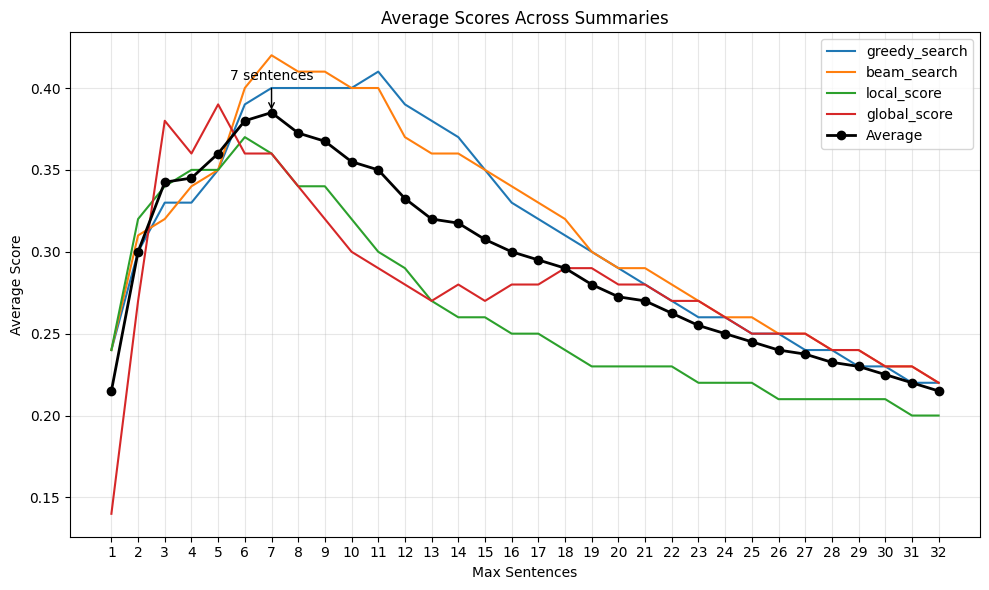

In [184]:
plot_avg_score(avg_score)

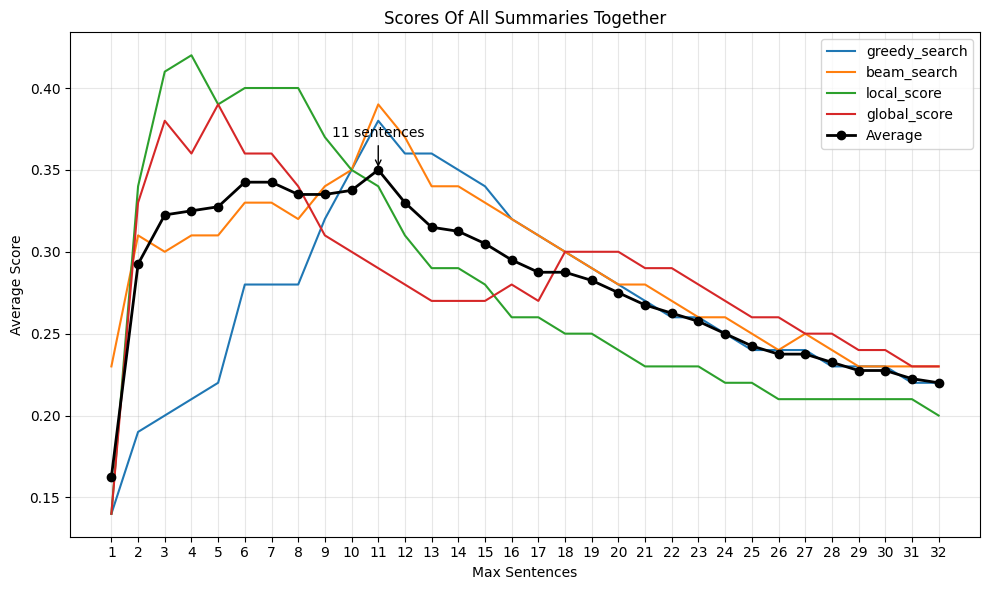

In [185]:
avg_score_all_tog = get_avg_across_summaries(score, ["all_together"])
plot_avg_score(avg_score_all_tog, "Scores Of All Summaries Together")

It seems that the best value for all the summaries together is around **7 Sentences** while for the big summary is around **11 sentences**. 

As we said before, while for local and greedy heuristics the results are reliable, they just are approximations for beam and global search. We now have an approximation of the range where to look for the best number of sentences, we can now re-run only beam and global heuristics in this range (to reduce complexity) and then check wether the results confirm or not the hhypotesis. 

### Evaluation

Let's make a function which, for each document, concatenates the sentences we have extracted from the selected list

In [ ]:
# Generated summaries concatenation
greedy_list_summaries_challenge_conc = sentence_concatenation(greedy_list_summaries_challenge)
beam_list_summaries_challenge_conc = sentence_concatenation(beam_list_summaries_challenge)
local_list_summaries_challenge_conc = sentence_concatenation(local_list_summaries_challenge)
global_list_summaries_challenge_conc = sentence_concatenation(global_list_summaries_challenge)

# Labels concatenation
#labels_challenge = sentence_concatenation(dataset_extractive["challenge_labels"])
labels_challenge = sentence_concatenation(dataset_extractive_temp["challenge_sentences"])

We now need the function in order to evaluate the average performances over the whole test set, base on **ROUGE F1**

In [ ]:
def avg_performance(predicted_summaries, label_summaries, eval_criteria):
    # In case something went wrong
    if len(predicted_summaries) != len(label_summaries):
        return None
    
    r1_sum = 0
    for pred, label in zip(predicted_summaries, label_summaries):
        r1 = rouge_score(pred, label, eval_criteria)
        r1_sum += r1
    
    return r1_sum / len(predicted_summaries)

In [ ]:
r1_greedy_challenge = avg_performance(greedy_list_summaries_challenge_conc, labels_challenge, evaluation_criteria)
print(f'The average ROUGE F-1 score for Greedy Search heuristic is: {round(r1_greedy_challenge, 5)}')
print(f'Time taken: {round(greedy_challenge_time, 1)}s')

The average ROUGE F-1 score for Greedy Search heuristic is: 0.00183
Time taken: 69.5s
